In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Kids Drawing - Insights using Pandas
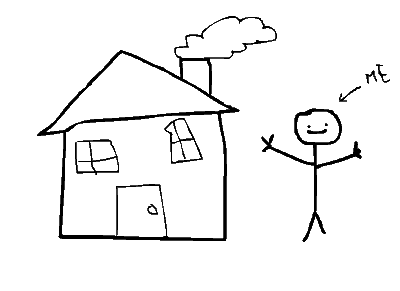

In this part, we will work with Datasets of **Kids Doodling** in order to recognize some insights/patterns in each drawing.  
For example:  
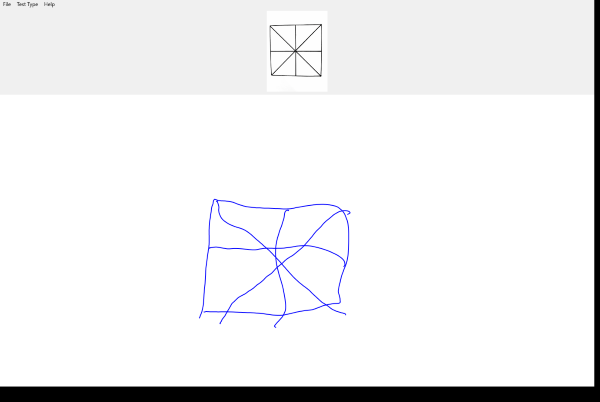

We will answer 4 main questions:
1. How many different lines this drawing contains? (in the drawing above **8**)
2. What is the **average pressure**  and the **length(euclidean distance)** of each line?  
3. How many times the kid who drew this doodle **raised his hand** during the doodling? (in the drawing above **5**)
4. Does this shape **open** or **close**? (in the drawing above **closed**)

First, we will load the dataset of one of the doodling.

In [2]:
drawing = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7554\SimpleTest\21.csv')
drawing.head(5)

,X,Y,Pressure,TiltX,TiltY,Time
0,719.415174962467,500.762675,0.321523,-4394.0,1116.0,00:03.8377831
1,720.468414366555,500.867999,0.326650,-4394.0,1116.0,00:03.8534071
2,720.995034068599,500.499365,0.260243,-4394.0,1116.0,00:03.8690233
3,720.415752396351,499.972745,0.270497,-4394.0,1116.0,00:03.8847364
4,718.677907379605,497.866266,0.285389,-4394.0,1116.0,00:03.9003241


### About the data
There are 5 features to this dataset:
* **X, Y** -> The index of the current sample in the original image (at what pixel this sample were taken). 
* **Pressure** -> The amount of pressure that the kid activated in the exact moment(smaple) while during the doodle.
* **TiltX, TiltY** -> The tilt of the pen in the exact moment (smaple) - in the X direction and in the Y direction.
* **Time** -> The time of this sample (in seconds) - starting with **00:00.0000000**.

## Data preprocessing
Before we procceed we need to check that there aren't any **NaN values**.

In [3]:
drawing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          656 non-null    object 
 1    Y         654 non-null    float64
 2    Pressure  654 non-null    float64
 3    TiltX     654 non-null    float64
 4    TiltY     654 non-null    float64
 5    Time      654 non-null    object 
dtypes: float64(4), object(2)
memory usage: 30.9+ KB


**Because we found some NaN values (and not to much) we will drop them.** 

In [4]:
drawing.dropna(axis = 0, inplace = True)

In [5]:
drawing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654 entries, 0 to 653
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          654 non-null    object 
 1    Y         654 non-null    float64
 2    Pressure  654 non-null    float64
 3    TiltX     654 non-null    float64
 4    TiltY     654 non-null    float64
 5    Time      654 non-null    object 
dtypes: float64(4), object(2)
memory usage: 35.8+ KB


**In each column there is a space which is irrelvant so we will remove it**

In [6]:
print("Before -> ", drawing.columns)
drawing.columns = drawing.columns.str.replace(' ', '')
print("After -> ", drawing.columns)

Before ->  Index(['X', ' Y', ' Pressure', ' TiltX', ' TiltY', ' Time'], dtype='object')
After ->  Index(['X', 'Y', 'Pressure', 'TiltX', 'TiltY', 'Time'], dtype='object')


The time is in an object and we want it as float so we will convert to a float type and because we want  
it simple we will combine the **minutes** and the **seconds** to one feature of seconds with the name of **sec**

In [7]:
time = drawing.Time.str.split(':', expand = True).astype('float64')
drawing['sec'] = time[0] * 60 + time[1]
drawing.drop('Time', axis = 1, inplace =True)
drawing = drawing.astype('float64')
drawing.head(5)

,X,Y,Pressure,TiltX,TiltY,sec
0,719.415175,500.762675,0.321523,-4394.0,1116.0,3.837783
1,720.468414,500.867999,0.326650,-4394.0,1116.0,3.853407
2,720.995034,500.499365,0.260243,-4394.0,1116.0,3.869023
3,720.415752,499.972745,0.270497,-4394.0,1116.0,3.884736
4,718.677907,497.866266,0.285389,-4394.0,1116.0,3.900324


Now we will use the difference between each sample to learn the behavior of the painting.  
We know that the samples are organized in increasing order which mean that it's in the order that the kid drew this.  
So if we will look at the difference between the **X** value of some index and the **X** value of the index after  
this value will tell us how much pixels  we passed between those two samples.  
We will do the same for **Y** and for **sec** and for **TiltX** and for **TiltY** and **Pressure**.

In [8]:
copy_d = drawing.shift()
diff_x = abs(drawing['X'] - copy_d['X'])
diff_y = abs(drawing['Y'] - copy_d['Y'])
diff_time = drawing['sec'] - copy_d['sec']
diff_tilt_x = abs(drawing['TiltX'] - copy_d['TiltX'])
diff_tilt_y = abs(drawing['TiltY'] - copy_d['TiltY'])
diff_pressure = abs(drawing['Pressure'] - copy_d['Pressure'])
drawing['last_x'] = diff_x
drawing['last_y'] = diff_y
drawing['last_sec'] = diff_time
drawing['diff_tilt_x'] = diff_tilt_x
drawing['diff_tilt_y'] = diff_tilt_y
drawing['diff_pressure'] = diff_pressure
drawing.head(10)

,X,Y,Pressure,TiltX,TiltY,sec,last_x,last_y,last_sec,diff_tilt_x,diff_tilt_y,diff_pressure
0,719.415175,500.762675,0.321523,-4394.0,1116.0,3.837783,NaN,NaN,NaN,NaN,NaN,NaN
1,720.468414,500.867999,0.326650,-4394.0,1116.0,3.853407,1.053239,0.105324,0.015624,0.0,0.0,0.005127
2,720.995034,500.499365,0.260243,-4394.0,1116.0,3.869023,0.526620,0.368634,0.015616,0.0,0.0,0.066407
3,720.415752,499.972745,0.270497,-4394.0,1116.0,3.884736,0.579282,0.526620,0.015713,0.0,0.0,0.010254
4,718.677907,497.866266,0.285389,-4394.0,1116.0,3.900324,1.737845,2.106479,0.015588,0.0,0.0,0.014893
5,717.098048,496.602379,0.297353,-4394.0,1116.0,3.915971,1.579859,1.263887,0.015647,0.0,0.0,0.011963
6,714.043654,494.021942,0.314931,-4394.0,1116.0,3.931515,3.054394,2.580437,0.015544,0.0,0.0,0.017578
7,712.042499,492.547407,0.325673,-4394.0,1116.0,3.931515,2.001155,1.474535,0.000000,0.0,0.0,0.010742
8,710.725950,491.546830,0.332509,-4394.0,1116.0,3.947137,1.316549,1.000577,0.015622,0.0,0.0,0.006836
9,708.672133,489.914309,0.341054,-4394.0,1116.0,3.962761,2.053817,1.632521,0.015624,0.0,0.0,0.008545


Now we will try using the difference features that we added to the dataset in oreder to know how many different lines this drawing contains.

We create a function that plot the drawing in a range of rows, so we could check our results.

In [9]:
scale=drawing['Y'].max()+drawing['Y'].min()
def plot_lines(x_points, y_points, symbol=None):
    plt.ylim(round(drawing['Y'].min()) - 5, round(drawing['Y'].max()) + 5)
    plt.xlim(round(drawing['X'].min()) - 5, round(drawing['X'].max()) + 5)
    if symbol != None:
        plt.plot(x_points, scale - y_points, symbol)
    else:
        plt.plot(x_points, scale - y_points)

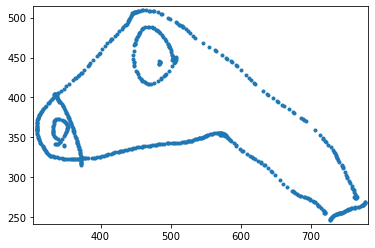

In [10]:
plot_lines(drawing['X'], drawing['Y'], '.')

### Find how many different lines the drawing contains

At first, we assumed that if the difference in the tilt is zero then the current rows represent a line and the tilt will increase when there is a break from the line.

So we created a function that checks if in this row the diff_TiltX\Y is **"small"** (less than 10 - closer to zero) and in the next row the diff_TiltX\Y is **"big"** more than 50.

In [11]:
def find_lines_by_tilt(df):
    tiltx=drawing.loc[(drawing['diff_tilt_x'].shift()>30) & (drawing['diff_tilt_x']<10)]
    index=tiltx.index
    index=index.insert(0,0)

    dfs=[tiltx]
    for i in range(1,len(index)):
        for j in range(index[i]-1,index[i-1],-1):
            if drawing.iloc[[j]].diff_tilt_x.item()>100:
                if i-j>5:
                    dfs=dfs.append(drawing.iloc[[j]])
                break            

    df=pd.concat(dfs).drop_duplicates()
    return df.sort_index()

But as we saw afterward our assumption was not true, we figured that even when the line breaks the tilt difference could stay very close to zero (as we can see in the next example)

Here is a rounded line so according to our assumption the tilt should not be zero through the entire line.

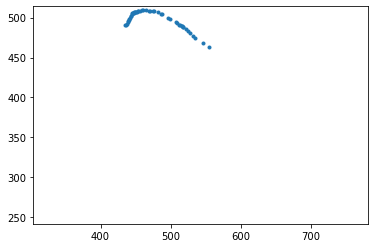

In [12]:
plot_lines(drawing['X'][130:180], drawing['Y'][130:180], '.')

But the tilt difference is staying zero through the entire line.

In [13]:
print(drawing[130:180].diff_tilt_x.sum())
print(drawing[130:180].diff_tilt_y.sum())

0.0
0.0


Our next idea was that the distance between the start point and the ending point (edges) of a line (x,y) should be closed to the sum of distances between all the points between the start and ending point.

We created a function that iterates over the data frame and when the difference between the distance between the edges of a line (x, y) and the sum of distances between all the points between x and y is large we check if (x, y) creates a line (more than a few samples)

In [14]:
def distance(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def find_lines(df,eps=10):
    line_size=len(df)/40
    lines=[]
    start=0
    total_dist=0
    p_s=(df.iloc[[0]].X.item(),df.iloc[[0]].Y.item())
    for i in range(1,len(df),2):
        p_f=(df.iloc[[i-2]].X.item(),df.iloc[[i-2]].Y.item())
        p_i=(df.iloc[[i]].X.item(),df.iloc[[i]].Y.item())
        total_dist+=distance(p_f,p_i)
        dist=distance(p_s,p_i)
        if abs(total_dist-dist)>eps or len(df)-i<=2:
            if i-start>line_size:
                lines.append((start,i-1))
            start=i
            p_s=(df.iloc[[i]].X.item(),df.iloc[[i]].Y.item())
            total_dist=0
    return lines

We find and draw the lines of the drawing.


After we succeeded to find the line we calculate the average pressure as the mean of all the samples from the start to the end of the line and the length of the line was calculated as the sum of distances between all the points between x and y.

Q1: There are 12 lines in this drawing

Line number 1, range: (1,60)
Distance ->  45.63144
Avarage Pressure ->  0.44559

Line number 2, range: (61,150)
Distance ->  370.84694
Avarage Pressure ->  0.60848

Line number 3, range: (151,242)
Distance ->  220.28079
Avarage Pressure ->  0.64215

Line number 4, range: (243,288)
Distance ->  67.65848
Avarage Pressure ->  0.67341

Line number 5, range: (289,402)
Distance ->  217.00354
Avarage Pressure ->  0.73900

Line number 6, range: (403,452)
Distance ->  423.75925
Avarage Pressure ->  0.35143

Line number 7, range: (453,518)
Distance ->  95.54311
Avarage Pressure ->  0.37963

Line number 8, range: (519,540)
Distance ->  34.56571
Avarage Pressure ->  0.33189

Line number 9, range: (541,562)
Distance ->  29.17777
Avarage Pressure ->  0.41557

Line number 10, range: (569,590)
Distance ->  56.74537
Avarage Pressure ->  0.25401

Line number 11, range: (591,618)
Distance ->  61.89074
Avarage Pressure ->  0.42083

Line number 12, range: (619,646)
D

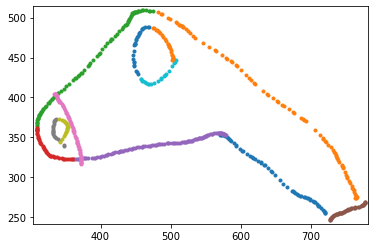

In [16]:
# this function calculates the avarge pressure of all the smaples between @start to @end
def find_avg_pressure(df, start, end):
    return df['Pressure'][start: end + 1].mean()

# this function calculates the euclidean distance from the (x,y) of @start to the (x,y) of @end
def find_dist(df, start, end):
    x = (df['X'][start] - df['X'][end]) ** 2
    y = (df['Y'][start] - df['Y'][end]) ** 2
    return np.sqrt(x + y)

lines=find_lines(drawing)

#plot all the lines
print(f'Q1: There are {len(lines)} lines in this drawing\n')
ind = 0
for line in lines:
    plot_lines(drawing['X'][line[0]: line[1]], drawing['Y'][line[0]: line[1]],'.')
    print(f'Line number {ind + 1}, range: ({line[0]},{line[1]})')
    print(f'Distance -> {find_dist(drawing, line[0], line[1]): .5f}')
    print(f'Avarage Pressure -> {find_avg_pressure(drawing, line[0], line[1]): .5f}\n')
    ind += 1

We can see that we detect pretty well the lines of the drawing, our function detect also the circles as 3\2 little lines but this is a reasonable way to treat them because all the drawing lines are not perfectly straight.

### Find how much hand-raising was in the drawing.

Our next mission is to know how many times the kid who drew this doodle raised his hand during the doodling.

Our first idea was to check when the pressure is almost zero because in those points the kid started to draw again.

In [17]:
drawing[drawing['Pressure'] <0.1]

,X,Y,Pressure,TiltX,TiltY,sec,last_x,last_y,last_sec,diff_tilt_x,diff_tilt_y,diff_pressure
403,727.893752,509.188590,0.030503,-3958.0,1625.0,10.720107,147.822150,103.217462,1.402136,275.0,1032.0,0.521492
404,727.893752,509.188590,0.030503,-3958.0,1625.0,10.735731,0.000000,0.000000,0.015623,0.0,0.0,0.000000
405,728.262386,508.872618,0.042710,-3958.0,1625.0,10.752452,0.368634,0.315972,0.016721,0.0,0.0,0.012207
406,728.841668,508.082689,0.063462,-3958.0,1625.0,10.768123,0.579282,0.789930,0.015671,0.0,0.0,0.020752
407,729.157639,507.714055,0.093248,-3958.0,1625.0,10.783941,0.315972,0.368634,0.015817,0.0,0.0,0.029786
452,333.929553,353.098510,0.028061,-3227.0,2362.0,21.443736,443.203141,133.603418,10.200283,1245.0,437.0,0.416754
453,334.140201,352.571891,0.030503,-3227.0,2362.0,21.459350,0.210648,0.526620,0.015614,0.0,0.0,0.002441


As we can see we found 2 points (403,452) where the pressure was close to zero and a few samples after each one the pressure still was small, so we can check those 2 first points.

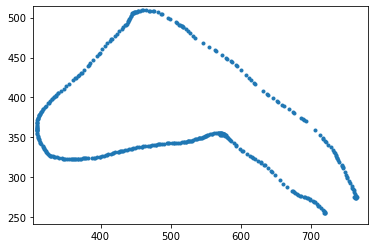

In [18]:
plot_lines(drawing['X'][0: 403], drawing['Y'][0: 403], '.')

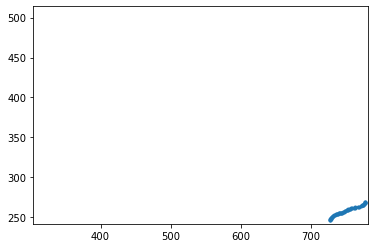

In [19]:
plot_lines(drawing['X'][403: 452], drawing['Y'][403: 452], '.')

The results are not bad, but we have not found all the hand raising and it looks like our first plot combines two hand-raising.

We try another idea, we assume that we can find the hand-raising by a significant difference in the x,y, or time, so we looking for samples that are greater than the mean+std for each feature.

In [20]:
drawing.describe()

,X,Y,Pressure,TiltX,TiltY,sec,last_x,last_y,last_sec,diff_tilt_x,diff_tilt_y,diff_pressure
count,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,493.651054,386.461720,0.530282,-3815.906728,2758.571865,14.644882,3.286333,2.050833,0.060444,10.683002,12.528331,0.007811
std,144.647266,69.198663,0.175200,359.658025,732.757949,12.219897,20.819887,8.474216,0.817799,67.735155,56.724319,0.032971
min,308.704469,247.195288,0.028061,-5042.000000,1116.000000,3.837783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,360.444855,333.363437,0.413321,-3958.000000,2257.000000,6.696632,0.579282,0.421296,0.000000,0.000000,0.000000,0.000000
50%,467.217000,402.074143,0.639155,-3727.000000,2699.000000,8.513089,1.263887,0.895253,0.015619,0.000000,0.000000,0.000000
75%,586.562190,429.563691,0.648920,-3586.000000,3474.000000,21.892904,2.580437,2.053817,0.015630,0.000000,0.000000,0.004151
max,777.238018,509.188590,0.746578,-3227.000000,3820.000000,43.307565,443.203141,133.603418,18.165692,1245.000000,1032.000000,0.521492


we realized that most of the points will be in the range of the **mean+std** because the std tells us how far most of the points from the mean.
in case that there is no hand raising out diff_time mean and std would be very small.

In [21]:
tresh_time = drawing['last_sec'].mean() + drawing['last_sec'].std()
tresh_x = drawing['last_x'].mean() + drawing['last_x'].std()
tresh_y = drawing['last_y'].mean() + drawing['last_y'].std()
print("Time Treshold: ", tresh_time)
print("X Treshold: ", tresh_x)
print("Y Treshold: ", tresh_y)

Time Treshold:  0.8782426372562684
X Treshold:  24.10621931876068
Y Treshold:  10.525049167305983


In [22]:
large_time_diff=drawing[drawing['last_sec'] > tresh_time]
large_time_diff

,X,Y,Pressure,TiltX,TiltY,sec,last_x,last_y,last_sec,diff_tilt_x,diff_tilt_y,diff_pressure
60,761.755399,481.435732,0.190661,-5042.0,2440.0,5.598896,191.215614,78.729645,1.093955,940.0,25.0,0.117189
403,727.893752,509.188590,0.030503,-3958.0,1625.0,10.720107,147.822150,103.217462,1.402136,275.0,1032.0,0.521492
452,333.929553,353.098510,0.028061,-3227.0,2362.0,21.443736,443.203141,133.603418,10.200283,1245.0,437.0,0.416754
567,508.398660,306.124033,0.103502,-3586.0,2533.0,41.484234,173.047234,108.746968,18.165692,314.0,319.0,0.032959
646,483.384225,314.602610,0.198962,-3410.0,2257.0,43.211846,19.010971,4.950225,0.888772,176.0,276.0,0.062745


In [23]:
large_x_diff=drawing[drawing['last_x'] > tresh_x]
large_x_diff

,X,Y,Pressure,TiltX,TiltY,sec,last_x,last_y,last_sec,diff_tilt_x,diff_tilt_y,diff_pressure
60,761.755399,481.435732,0.190661,-5042.0,2440.0,5.598896,191.215614,78.729645,1.093955,940.0,25.0,0.117189
403,727.893752,509.188590,0.030503,-3958.0,1625.0,10.720107,147.822150,103.217462,1.402136,275.0,1032.0,0.521492
452,333.929553,353.098510,0.028061,-3227.0,2362.0,21.443736,443.203141,133.603418,10.200283,1245.0,437.0,0.416754
567,508.398660,306.124033,0.103502,-3586.0,2533.0,41.484234,173.047234,108.746968,18.165692,314.0,319.0,0.032959


In [24]:
large_y_diff=drawing[drawing['last_y'] > tresh_y]
large_y_diff

,X,Y,Pressure,TiltX,TiltY,sec,last_x,last_y,last_sec,diff_tilt_x,diff_tilt_y,diff_pressure
60,761.755399,481.435732,0.190661,-5042.0,2440.0,5.598896,191.215614,78.729645,1.093955,940.0,25.0,0.117189
403,727.893752,509.188590,0.030503,-3958.0,1625.0,10.720107,147.822150,103.217462,1.402136,275.0,1032.0,0.521492
452,333.929553,353.098510,0.028061,-3227.0,2362.0,21.443736,443.203141,133.603418,10.200283,1245.0,437.0,0.416754
519,347.726989,416.661508,0.189441,-3355.0,2041.0,22.803021,23.750549,23.855873,0.578127,447.0,620.0,0.215091
567,508.398660,306.124033,0.103502,-3586.0,2533.0,41.484234,173.047234,108.746968,18.165692,314.0,319.0,0.032959


As we can see all the options gave us almost the same result, let's try union them and see the plot.

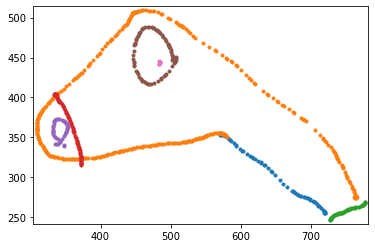

In [25]:
raised_hand=pd.concat([large_time_diff,large_x_diff,large_y_diff]).drop_duplicates()
#plot of all the hand raising
curr = 0
index = sorted(raised_hand.index.values.astype(int))
index.append(len(drawing['X']))
for ind in index:
    plot_lines(drawing['X'][curr: ind], drawing['Y'][curr: ind], '.')
    curr = ind
plt.show()

Wow, our algorithm found all of the hand-raising and it looks very good.

Now after we saw the process of finding the algorithm let's have a look how well our algorithm works on new drawings.

## The algorithm

In [26]:
def plot_lines(df,x_points, y_points,scale, symbol=None):
    plt.ylim(round(df['Y'].min()) - 5, round(df['Y'].max()) + 5)
    plt.xlim(round(df['X'].min()) - 5, round(df['X'].max()) + 5)
    if symbol != None:
        plt.plot(x_points, scale - y_points, symbol)
    else:
        plt.plot(x_points, scale - y_points)
        
def algo(df):
    #add features to the data frame that would help us find lines and hand raising
    df.dropna(axis = 0, inplace = True)
    df.columns = df.columns.str.replace(' ','')
    time=df.Time.str.split(':',expand = True).astype('float64',)
    df.drop('Time', axis = 1, inplace = True)
    df[['sec']]=time[0]*60+time[1]
    df = df.astype(float)
    df['diff_sec'] = df['sec']-df.sec.shift()
    df['diff_X'] = abs(df.X.shift()-df['X'])
    df['diff_Y'] = abs(df.Y.shift()-df['Y'])
    scale=df['Y'].max()+df['Y'].min()
    lines=find_lines(df)
    tresh_time=df.mean()[6]+df.std()[6]
    tresh_x=df.mean()[7]+df.std()[7]
    tresh_y=df.mean()[8]+df.std()[8]
    
    #set 3 sub data frame by our tresholds
    large_time_diff=df[df['diff_sec'] > tresh_time]
    large_x_diff=df[df['diff_X'] > tresh_x]
    large_y_diff=df[df['diff_Y'] > tresh_y]
    
    # find the minimum number of hand raising that found
    size_x=len(large_x_diff)
    size_y=len(large_y_diff)
    size_time=len(large_time_diff)
    size_min=min(size_time,size_x,size_y)
    
    raised_hand_list=[]        
    if tresh_time>0.02:
        # if all the data frames have the same size we union them all 
        if size_time==size_x==size_y:
            raised_hand_list=[large_x_diff,large_y_diff,large_time_diff]

        # if we found 2 sub data frames that found same number of hand raising and this the minimum number
        # we union those 2 data frames
        elif size_min==size_x==size_y:
            raised_hand_list=[large_x_diff,large_y_diff]
        elif size_min==size_x==size_time:
            raised_hand_list=[large_x_diff,large_time_diff]
        elif size_min==size_time==size_y:
            raised_hand_list=[large_y_diff,large_time_diff]

        # if we dont have 2 data frames with the same size we union only those who close to the minimum
        # so we dont get outliers
        elif len(raised_hand_list)==0:
            if size_x<=size_min+10:
                raised_hand_list.append(large_x_diff)
            if size_y<=size_min+10:
                raised_hand_list.append(large_y_diff)
            if size_time<=size_min+10:
                raised_hand_list.append(large_time_diff)

        # union the data frames
        raised_hand=pd.concat(raised_hand_list).drop_duplicates()
    
    #plot all the lines
    print(f'Q1: There are {len(lines)} lines in this drawing\n')
    pressures=[]
    length=[]
    plt.title('Different lines')
    for line in lines:
        plot_lines(df,df['X'][line[0]: line[1]], df['Y'][line[0]: line[1]],scale, '.')
        pressures.append(find_avg_pressure(df, line[0], line[1]))
        length.append(find_dist(df, line[0], line[1]))
    plt.show()
    print("Q2: Avarage Pressures for each line")
    print(pressures)
    print()
    print("Q2: Distances for each line")
    print(length)
    
    
    #plot all the hand raising
    plt.title('Hand raising')
    if len(raised_hand_list)==0:
        print(f'\nQ3: There are 0 hand raising in this drawing\n')
        plot_lines(df,df['X'][0: len(df)], df['Y'][0: len(df)],scale, '.')
    else:
        print(f'\nQ3: There are {len(raised_hand)} hand raising in this drawing\n')
        curr = 0
        index = sorted(raised_hand.index.values.astype(int))
        index.append(len(df['X']))
        for ind in index:
            plot_lines(df,df['X'][curr: ind], df['Y'][curr: ind],scale, '.')
            curr = ind
    plt.show()
    
    # detact if the draw shape is opened\closed
    eps=15
    p1=(df.iloc[[len(df)-1]].X.item(),df.iloc[[len(df)-1]].Y.item())
    opened=True
    for i in range(20):
        p2=(df.iloc[[i]].X.item(),df.iloc[[i]].Y.item())
        if distance(p1,p2)<eps:
            opened=False
            break
    print("\nQ4: The shape draw is opened") if opened else print("\nQ4: The shape draw is closed")
        

After we try our algorithm on other drawings, we saw that union all the points we found do not always give us the best result.

Sometimes one of our metrics found a lot more than the others so we fixed it as we can see in the algorithm above.

In addition, we can see in the first 3 drawings that our algorithm "knows" if the shape is opened or closed.(to answer this question we checked if the last sample of the draw is "close" to the 20 first samples)

## Conclusions:
* We saw that our algorithm detects very well how much hand-raising was in the drawing.
* Unlike the former mission. The mission to recognize how many lines were in the drawing is more difficult since all the lines in the drawing are not perfectly straight so to detect the lines, we needed to compromise. hence we have false-positive lines such as parts from circles.
* We gained new knowledge for our algorithm from each drawing. For example, we saw that one way to find hand-raising that worked on one drawing is not Necessarily will work on another one, So we needed to improve our algorithm so it would work in general.

## Examples
We now draw plots for each example, in our plots each color refers to a different line\hand raising.

Q1: There are 5 lines in this drawing



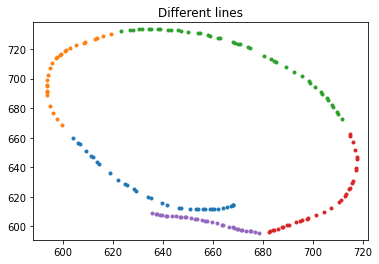

Q2: Avarage Pressures for each line
[0.7585819289088249, 0.8745272372450147, 0.9371540650077488, 0.9671697616577148, 0.9595195187462701]

Q2: Distances for each line
[82.85898721384835, 65.54691388885176, 110.71331038439114, 74.56564924726113, 46.26263414261347]

Q3: There are 0 hand raising in this drawing



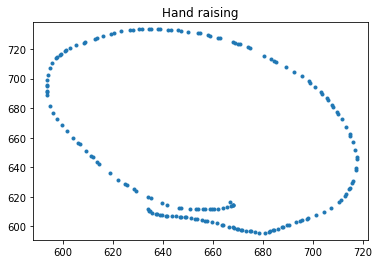


Q4: The shape draw is closed


In [27]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7558\SimpleTest\3.csv')
algo(img)

Q1: There are 6 lines in this drawing



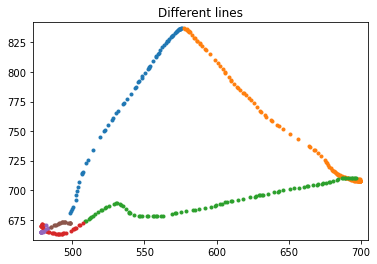

Q2: Avarage Pressures for each line
[0.7713752082034724, 0.9762001351035875, 0.9916278837869564, 0.909300372714088, 0.29110943738903305, 0.543340203166008]

Q2: Distances for each line
[175.03214125883852, 174.57342246600487, 192.5633673653476, 26.79288684283177, 3.2874738422289336, 14.805882719337763]

Q3: There are 1 hand raising in this drawing



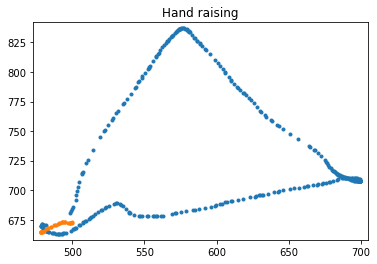


Q4: The shape draw is closed


In [28]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7558\SimpleTest\4.csv')
algo(img)

Q1: There are 6 lines in this drawing



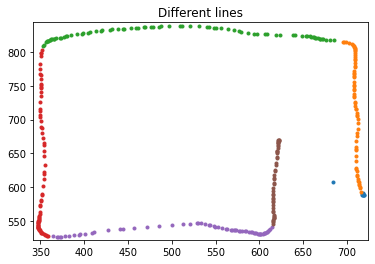

Q2: Avarage Pressures for each line
[0.21241474300622937, 0.7559814222834327, 0.9329377143848233, 0.8859218971149342, 0.8813051608475772, 0.8969507465759912]

Q2: Distances for each line
[35.7076507331133, 224.77891410772415, 333.32467153538215, 276.2185599139886, 249.87422855200595, 124.77198944634142]

Q3: There are 1 hand raising in this drawing



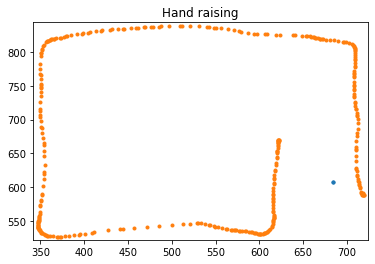


Q4: The shape draw is opened


In [29]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7558\SimpleTest\6.csv')
algo(img)

Q1: There are 12 lines in this drawing



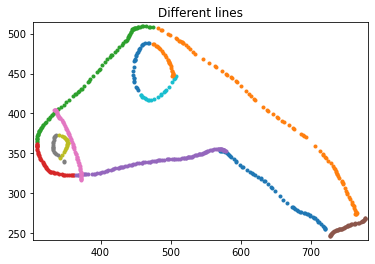

Q2: Avarage Pressures for each line
[0.44559293960531554, 0.6084846902224752, 0.6421480852624645, 0.673414470061012, 0.7389968419284151, 0.35142565086483957, 0.3796292045012568, 0.33188788999210694, 0.4155739112333818, 0.2540058385242115, 0.4208285627620561, 0.41277179867029196]

Q2: Distances for each line
[45.63143764615827, 370.8469440045627, 220.2807912450717, 67.6584794353965, 217.00353849629013, 423.7592514013347, 95.54311057688125, 34.565714240100945, 29.177773181338818, 56.74536833867153, 61.890743833883455, 46.42399846634126]

Q3: There are 6 hand raising in this drawing



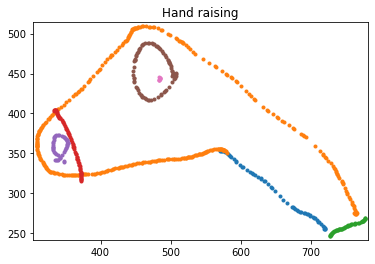


Q4: The shape draw is opened


In [30]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7554\SimpleTest\21.csv')
algo(img)

Q1: There are 15 lines in this drawing



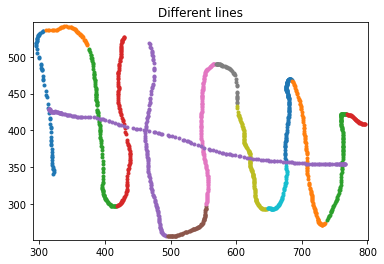

Q2: Avarage Pressures for each line
[0.5715419198386371, 0.6671357115973597, 0.6848158518136558, 0.752008338769277, 0.6351085507100628, 0.6361997960244908, 0.6216607639422784, 0.6214966307515684, 0.6577997702818651, 0.6083924644268477, 0.5886303434769312, 0.6227881041440096, 0.6564208097182789, 0.6483357595769983, 0.6289810383353721]

Q2: Distances for each line
[196.25234814788317, 66.76410145871762, 217.00928937422404, 231.07417842202426, 263.7348114340741, 71.24526213149636, 191.99448634417448, 65.3458662576403, 146.73115274202726, 70.35150423564583, 108.58685001169474, 198.70527480176037, 147.33988279796438, 29.545993572694076, 457.0016606501248]

Q3: There are 1 hand raising in this drawing



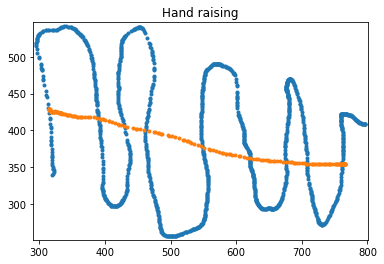


Q4: The shape draw is opened


In [31]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7554\SimpleTest\17.csv')
algo(img)


Q1: There are 8 lines in this drawing



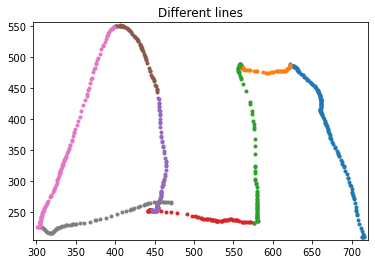

Q2: Avarage Pressures for each line
[0.5883780951097385, 0.41592024142543466, 0.5401419127359987, 0.42415939023097354, 0.5533615317075483, 0.6252733170986176, 0.608463675994426, 0.6240731884132732]

Q2: Distances for each line
[290.75194546418027, 63.41760775826656, 255.05122409391703, 128.8556735989604, 182.60833369179068, 117.4552495030215, 335.4573661068396, 170.6062694998044]

Q3: There are 3 hand raising in this drawing



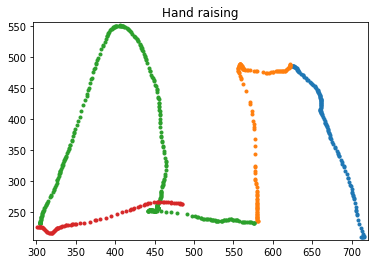


Q4: The shape draw is opened


In [32]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7554\SimpleTest\20.csv')
algo(img)

Q1: There are 6 lines in this drawing



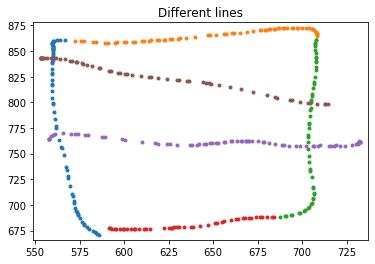

Q2: Avarage Pressures for each line
[0.693257760913933, 0.8387019688432867, 0.8885873364550726, 0.9245010031306226, 0.7726373597979546, 0.6816593945747421]

Q2: Distances for each line
[189.9704354243237, 135.80704288881896, 174.03786840664233, 94.72939949917942, 174.16128856475382, 168.08137620543692]

Q3: There are 2 hand raising in this drawing



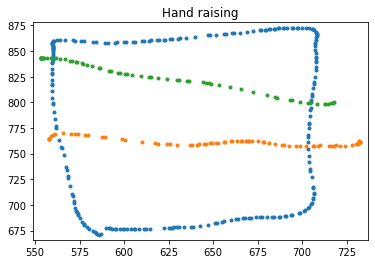


Q4: The shape draw is opened


In [33]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7558\SimpleTest\19.csv')
algo(img)

Q1: There are 17 lines in this drawing



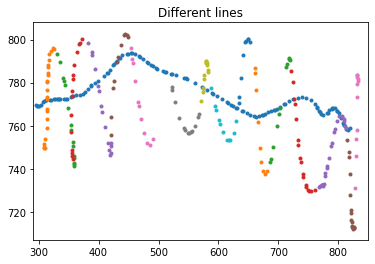

Q2: Avarage Pressures for each line
[0.6877036892450773, 0.5600111869474252, 0.7527885884046556, 0.7083543129265308, 0.6748455017805101, 0.488537924985091, 0.5716690768798193, 0.5612377396651675, 0.5793218399797164, 0.6017395108938217, 0.5738460302352906, 0.6096864283084868, 0.5988301386435827, 0.6180632942252691, 0.7056651940712562, 0.7657587490975858, 0.71935606499513]

Q2: Distances for each line
[528.4773836748017, 48.660686340599135, 58.75652979982112, 59.485419332779415, 58.54876755477814, 52.51507541294968, 55.18944327356949, 49.65987490800177, 16.45726591498582, 46.0433095155083, 33.14183097417829, 52.159521531048114, 56.17331677755069, 68.05463030388987, 51.60134147448259, 34.11146345836012, 46.40096370042625]

Q3: There are 1 hand raising in this drawing



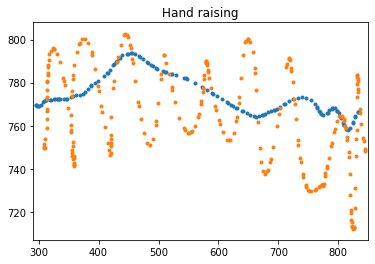


Q4: The shape draw is opened


In [34]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7558\SimpleTest\17.csv')
algo(img)

Q1: There are 4 lines in this drawing



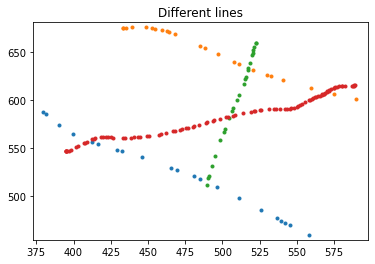

Q2: Avarage Pressures for each line
[0.42259861139411287, 0.3360901282479365, 0.39004289760039396, 0.506443045595113]

Q2: Distances for each line
[102.73513591617059, 177.17504535802223, 170.0435528456339, 206.6405920234149]

Q3: There are 3 hand raising in this drawing



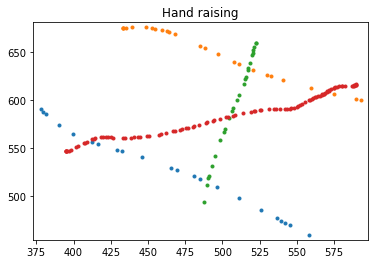


Q4: The shape draw is opened


In [35]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7558\SimpleTest\12.csv')
algo(img)

Q1: There are 10 lines in this drawing



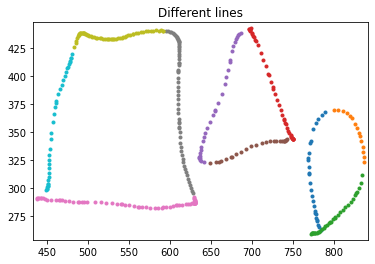

Q2: Avarage Pressures for each line
[0.43115234375, 0.568756103515625, 0.6412285698784722, 0.6353426846590909, 0.5237534466911765, 0.6563251201923077, 0.6308627658420138, 0.7648059475806451, 0.8061090284778226, 0.7735788445723685]

Q2: Distances for each line
[106.71227952159158, 62.412260636654615, 188.5673610263574, 11.571047231248421, 122.90822213930439, 96.65082853369658, 189.69393330844238, 148.35555275765, 110.666533712897, 126.13806431622659]

Q3: There are 3 hand raising in this drawing



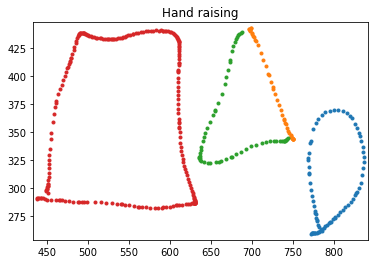


Q4: The shape draw is opened


In [36]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7569\SimpleTest\16.csv')
algo(img)

Q1: There are 9 lines in this drawing



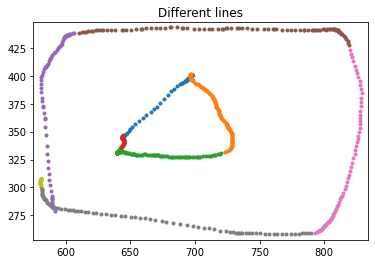

Q2: Avarage Pressures for each line
[0.3809521484375, 0.5664351029829545, 0.7100785688920455, 0.7211439344618056, 0.635284423828125, 0.6993607501594388, 0.8473680284288194, 0.8673386346726191, 0.8248937270220589]

Q2: Distances for each line
[0.8643317907172925, 74.61688774071902, 77.4268132030357, 77.15757325830812, 160.34249686435078, 209.8888094589874, 166.7389449296414, 212.6266869568588, 5.7284291040389]

Q3: There are 2 hand raising in this drawing



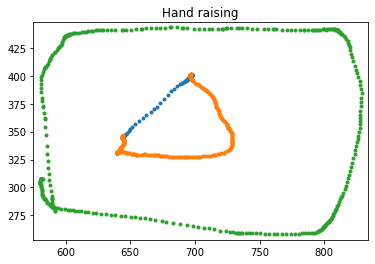


Q4: The shape draw is opened


In [37]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7569\SimpleTest\8.csv')
algo(img)

Q1: There are 6 lines in this drawing



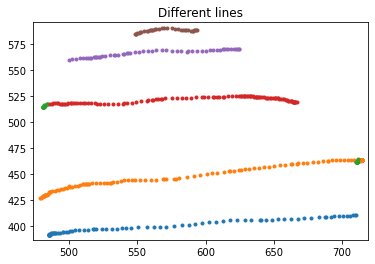

Q2: Avarage Pressures for each line
[0.6807798727964743, 0.5634852818080357, 0.5277099609375, 0.7426378973599138, 0.5050343480603449, 0.3887464735243056]

Q2: Distances for each line
[225.0561050111234, 234.60938109973355, 231.97599466324095, 44.13512058944104, 54.70702621566167, 45.200880645305034]

Q3: There are 4 hand raising in this drawing



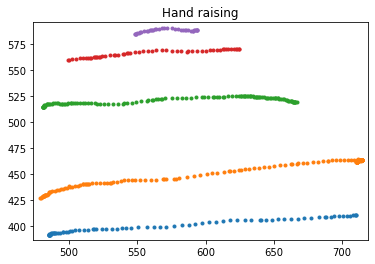


Q4: The shape draw is opened


In [38]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7569\SimpleTest\9.csv')
algo(img)

Q1: There are 10 lines in this drawing



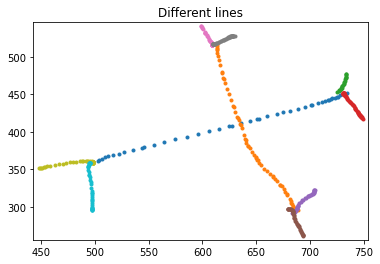

Q2: Avarage Pressures for each line
[0.4695408033288043, 0.6578962053571429, 0.33678089488636365, 0.4000439453125, 0.46494140625, 0.4356282552083333, 0.26729808134191174, 0.528106689453125, 0.4985990978422619, 0.5660691034226191]

Q2: Distances for each line
[250.38002505081053, 129.3026440205087, 26.077649007871543, 166.87928406693962, 37.55544176614088, 38.22233567489556, 1.444222205125767, 22.852804593261343, 2.5649999999999977, 63.35272817614933]

Q3: There are 9 hand raising in this drawing



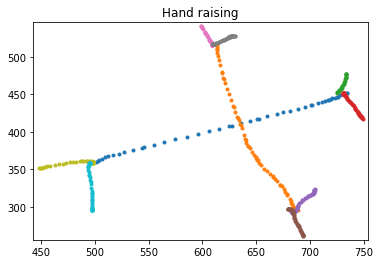


Q4: The shape draw is opened


In [39]:
img = pd.read_csv(r'C:\Users\sandl\.ipynb_checkpoints\train\7569\SimpleTest\10.csv')
algo(img)